# Description de la composition des clusters

- Calculer l'importance relative des variables
- Décrire chaque cluster (persona) par la moyenne et l'écart type de chaque variable à l'intérieur du cluster
- Pour chaque cluster afficher les variables les plus distinctives (par leur présence ou leur absence)

In [2]:
# Library
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggtext)
library(tidytext)

# Load Data and Clustering Results
kmeans_result <- readRDS("../../_PrivateFolder_datagotchi_federal_2025/data/clustering/can2025/03_pilot_kmeans.rds") # nolint
df_pilot_2025 <- readRDS("../../_PrivateFolder_datagotchi_federal_2025/data/clustering/can2025/03_pilot_2025.rds")

In [3]:
getwd()

[1] "/Users/sarah-janevincent/Library/CloudStorage/Dropbox/clessn_capp/datagotchi/datagotchi_federal_2024/sjvin/cluster_baselineCan2025"

In [4]:
# Identifier les variables qui ont été utilisées pour la construction 
# des clusters à analyser
vars_clusters <- colnames(df_pilot_2025)[colnames(df_pilot_2025) %in% colnames(kmeans_result$centers)] # nolint: line_length_linter.

## Calcul de l'importance relative des variables utilisées pour le clustering

- Mesure l’importance relative des variables en comparant leurs moyennes par cluster à la moyenne globale.
- Utilise l’écart-type pour rendre les différences comparables entre variables.
- Normalise les scores pour les exprimer en proportions.

💡 Utilisation : Identifier quelles variables différencient le plus les clusters dans une segmentation.

In [5]:
# Fonction pour calculer l'importance relative de chaque variable 
# dans la création des clusters -----------------------------

# Fonction pour calculer l'importance relative des variables dans le clustering
calculate_importance <- function(data, variables) {
  importance_scores <- sapply(variables, function(var) {
    overall_mean <- mean(data[[var]], na.rm = TRUE)
    cluster_means <- tapply(data[[var]], data$cluster, mean, na.rm = TRUE)
    abs_diff <- abs(cluster_means - overall_mean) / sd(data[[var]], na.rm = TRUE)
    return(mean(abs_diff, na.rm = TRUE))
  })
  importance_scores <- importance_scores / sum(importance_scores)  # Normaliser
  return(importance_scores)
}

In [6]:
# Calcul du score d'importance relatif pour chaque variable
importance_scores <- calculate_importance(df_pilot_2025, vars_clusters)
importance_scores <- signif(importance_scores[order(desc(importance_scores))], 4)
cat(paste(names(importance_scores), ":", importance_scores, collapse = "\n"))

lifestyle_exerciseYoga : 0.08493
lifestyle_clothingStyleOther : 0.07079
lifestyle_consCoffeeIndependent : 0.06084
lifestyle_ownPetNone : 0.0561
lifestyle_ownPetCat : 0.0514
lifestyle_ownPetDog : 0.04979
ses_incomeLow : 0.04456
lifestyle_consCoffeeNone : 0.04226
ses_languageFrench : 0.03998
lifestyle_consCoffeeTimHortons : 0.03823
ses_regionQuebec : 0.03799
lifestyle_goHuntingFreq_numeric : 0.0357
lifestyle_smokeFreq : 0.03525
ses_educUniv : 0.03491
lifestyle_hasTattoos : 0.03086
ses_immigrant : 0.03041
lifestyle_typeTransportNoCar : 0.02859
ses_dwellingDetachedHouse : 0.02789
lifestyle_exerciseGym : 0.02778
ses_dwellingApp : 0.0277
ses_educBHS : 0.02697
ses_incomeHigh : 0.02638
lifestyle_exerciseNone : 0.01876
lifestyle_favAlcoolDontDrink : 0.0169
lifestyle_consClothesFrip : 0.01665
lifestyle_favAlcoolWhiteWine : 0.01573
lifestyle_eatMeatFreq : 0.01505
lifestyle_favAlcoolRedWine : 0.007565

## Décrire les personas

Calcule les moyennes et écarts-types de chaque variable par cluster

In [7]:
# Fonction pour décrire les personas en affichant les moyennes et écarts-types par cluster
# (La variable "cluster" doit déjà être présente et factorisée dans data)
describe_personas <- function(data, variables) {
  persona_summary <- data %>%
    group_by(cluster) %>%
    summarise(across(all_of(variables), list(X_mean = ~mean(.x, na.rm = TRUE),
                                               X_sd = ~sd(.x, na.rm = TRUE))))
  return(persona_summary)
}

In [8]:
# Afficher les statistiques descriptives par cluster
describe_personas(df_pilot_2025, vars_clusters)

cluster,lifestyle_exerciseGym_X_mean,lifestyle_exerciseGym_X_sd,lifestyle_exerciseYoga_X_mean,lifestyle_exerciseYoga_X_sd,lifestyle_exerciseNone_X_mean,lifestyle_exerciseNone_X_sd,lifestyle_goHuntingFreq_numeric_X_mean,lifestyle_goHuntingFreq_numeric_X_sd,lifestyle_clothingStyleOther_X_mean,...,ses_educUniv_X_mean,ses_educUniv_X_sd,ses_incomeLow_X_mean,ses_incomeLow_X_sd,ses_incomeHigh_X_mean,ses_incomeHigh_X_sd,ses_languageFrench_X_mean,ses_languageFrench_X_sd,ses_regionQuebec_X_mean,ses_regionQuebec_X_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.42553191,0.4970745,0,0,0.042553191,0.20292981,0.55851064,0.3427936,0,...,0.4255319,0.4970745,0.08510638,0.2805361,0.11702128,0.3231692,0.170212766,0.37783474,0.23404255,0.4256692
2,0.12307692,0.3297964,0,0,0.038461538,0.19305163,0.07692308,0.1810985,0,...,0.5307692,0.5009829,0.02307692,0.1507287,0.30769231,0.4633239,0.153846154,0.36219697,0.16923077,0.3764061
3,0.06206897,0.2421171,0,0,0.179310345,0.38494165,0.03448276,0.1630351,0,...,0.3862069,0.4885666,0.07586207,0.2656951,0.05517241,0.2291079,0.965517241,0.18309807,0.98620690,0.1170355
4,0.32835821,0.4713781,0,0,0.007462687,0.08638684,0.04850746,0.1485444,0,...,0.7985075,0.4026202,0.05223881,0.2233432,0.23134328,0.4232737,0.052238806,0.22334316,0.10447761,0.3070269
5,0.12500000,0.3328055,0,0,0.162500000,0.37123639,0.05000000,0.1509464,0,...,0.1625000,0.3712364,0.91250000,0.2843491,0.00000000,0.0000000,0.337500000,0.47584036,0.36250000,0.4837551
6,0.03773585,0.1911588,0,0,0.106918239,0.30998561,0.04088050,0.1485005,0,...,0.3522013,0.4791655,0.05660377,0.2318141,0.13836478,0.3463734,0.006289308,0.07930516,0.02515723,0.1570973
7,0.16778523,0.3749358,0,0,0.100671141,0.30190759,0.07046980,0.1929512,0,...,0.3825503,0.4876490,0.08053691,0.2730404,0.09395973,0.2927567,0.315436242,0.46625663,0.36912752,0.4841961
8,0.22388060,0.4199890,0,0,0.074626866,0.26477165,0.05223881,0.1540938,0,...,0.7611940,0.4295717,0.10447761,0.3081877,0.19402985,0.3984366,0.388059701,0.49098614,0.44776119,0.5010166
9,0.14634146,0.3578390,0,0,0.121951220,0.33129458,0.10975610,0.2374920,1,...,0.2926829,0.4606464,0.24390244,0.4347694,0.09756098,0.3004062,0.390243902,0.49386480,0.39024390,0.4938648


## Identification des variables distinctives

Pour chaque cluster, identifier les variables qui le distingue des autres clusters.

1. Calculer les moyennes globlale et par cluster de chaque variable
1. Associer une couleur (rouge, vert, noir) à chaque variable de chaque cluster en fonction de la capacité de la variable à distinguer le cluster
1. Afficher sous forme de graphique la différence entre la moyenne du cluster et la moyenne globale pour chaque variable de chaque cluster. 

Dans les graphiques, les variables distinctives seront colorées en 

- rouge si leur moyenne dans le cluster est significativement sous la moyenne globale. On dira que leur absence caractérise le cluster.
- vert si leur moyenne est significativement au-dessus de la moyenne globale. On dira que leur présence caractérise le cluster.

In [9]:
# Produire une table contenant la valeur moyenne pour chaque
# variable (mean_overall) et la valeur moyenne par variable par
# cluster (mean_per_cluster)
df_means <- df_pilot_2025 %>%
  select(all_of(vars_clusters), cluster_name) %>%
  pivot_longer(cols = -cluster_name, names_to = "variable", values_to = "value") %>%
  group_by(variable) %>%
  mutate(mean_overall = mean(value, na.rm = TRUE)) %>%
  group_by(variable, cluster_name) %>%
  summarise(mean_per_cluster = mean(value, na.rm = TRUE), mean_overall = first(mean_overall), .groups = "drop")


In [10]:
# Fonction pour déterminer la couleur d'une variable binaire
#   Black : La variable ne distingue pas le cluster
#   Red : La variable distingue le cluster par son absence
#   Green : La variable distingue le cluster par sa présence
calculate_binary_color <- function(cluster_data, df, var) {
  prop_cluster <- mean(cluster_data[[var]], na.rm = TRUE)
  prop_overall <- mean(df[[var]], na.rm = TRUE)
  
  # Test de proportion
  p_value <- prop.test(
    x = c(sum(cluster_data[[var]]), sum(df[[var]])), 
    n = c(nrow(cluster_data), nrow(df))
  )$p.value
  
  # Calcul de la différence des proportions
  prop_diff <- abs(prop_cluster - prop_overall)
  
  # Déterminer la couleur selon les résultats du test
  if (p_value < 0.1 && prop_diff > 0.05) {
    return(ifelse(prop_cluster > prop_overall, "green", "red"))
  } else {
    return("black")
  }
}

In [11]:
# Fonction pour déterminer la couleur d'une variable continue
#   Black : La variable ne distingue pas le cluster
#   Red : La variable distingue le cluster par son absence
#   Green : La variable distingue le cluster par sa présence
calculate_continuous_color <- function(cluster_data, df, var) {
  # Test de Student
  t_test <- t.test(cluster_data[[var]], df[[var]])
  
  # Calcul de la taille d'effet (Cohen's d)
  effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(df[[var]], na.rm = TRUE)
  
  # Déterminer la couleur selon le p-value et la taille d'effet
  if (t_test$p.value < 0.1 && effect_size > 0.05) {
    return(ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"))
  } else {
    return("black")
  }
}

In [12]:
# Pour chaque variable de chaque cluster, associer une couleur selon
# la capacité de la variable à caractériser un cluster
#   Black : La variable ne distingue pas le cluster
#   Red : La variable distingue le cluster par son absence
#   Green : La variable distingue le cluster par sa présence
dfUsedForClustering <- df_pilot_2025
variablesUsedForClustering <- vars_clusters

# Créer un dataframe vide pour stocker les résultats
df_colors <- data.frame(cluster_name = character(), variable = character(), color = character(), stringsAsFactors = FALSE)  #nolint

# Boucle pour traiter chaque cluster
for (cluster_value in unique(dfUsedForClustering$cluster_name)) {
  # Filtrer les données pour le cluster actuel
  cluster_data <- dfUsedForClustering %>% filter(cluster_name == cluster_value)

  # Identification des caractéristiques marquantes
  characteristic_vars <- sapply(variablesUsedForClustering, function(var) {
    if (all(dfUsedForClustering[[var]] %in% c(0, 1))) {
      # Si la variable est binaire, on utilise la fonction pour binaire
      return(calculate_binary_color(cluster_data, dfUsedForClustering, var))
    } else {
      # Si la variable est continue, on utilise la fonction pour continue
      return(calculate_continuous_color(cluster_data, dfUsedForClustering, var))
    }
  })

  # Ajouter les résultats pour ce cluster dans le tableau global
  cluster_results <- data.frame(
    cluster_name = rep(cluster_value, length(variablesUsedForClustering)),
    variable = variablesUsedForClustering,
    color = characteristic_vars,
    stringsAsFactors = FALSE
  )

  # Fusionner les résultats du cluster avec le dataframe global
  df_colors <- bind_rows(df_colors, cluster_results)
}
rownames(df_colors) <- NULL

Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster

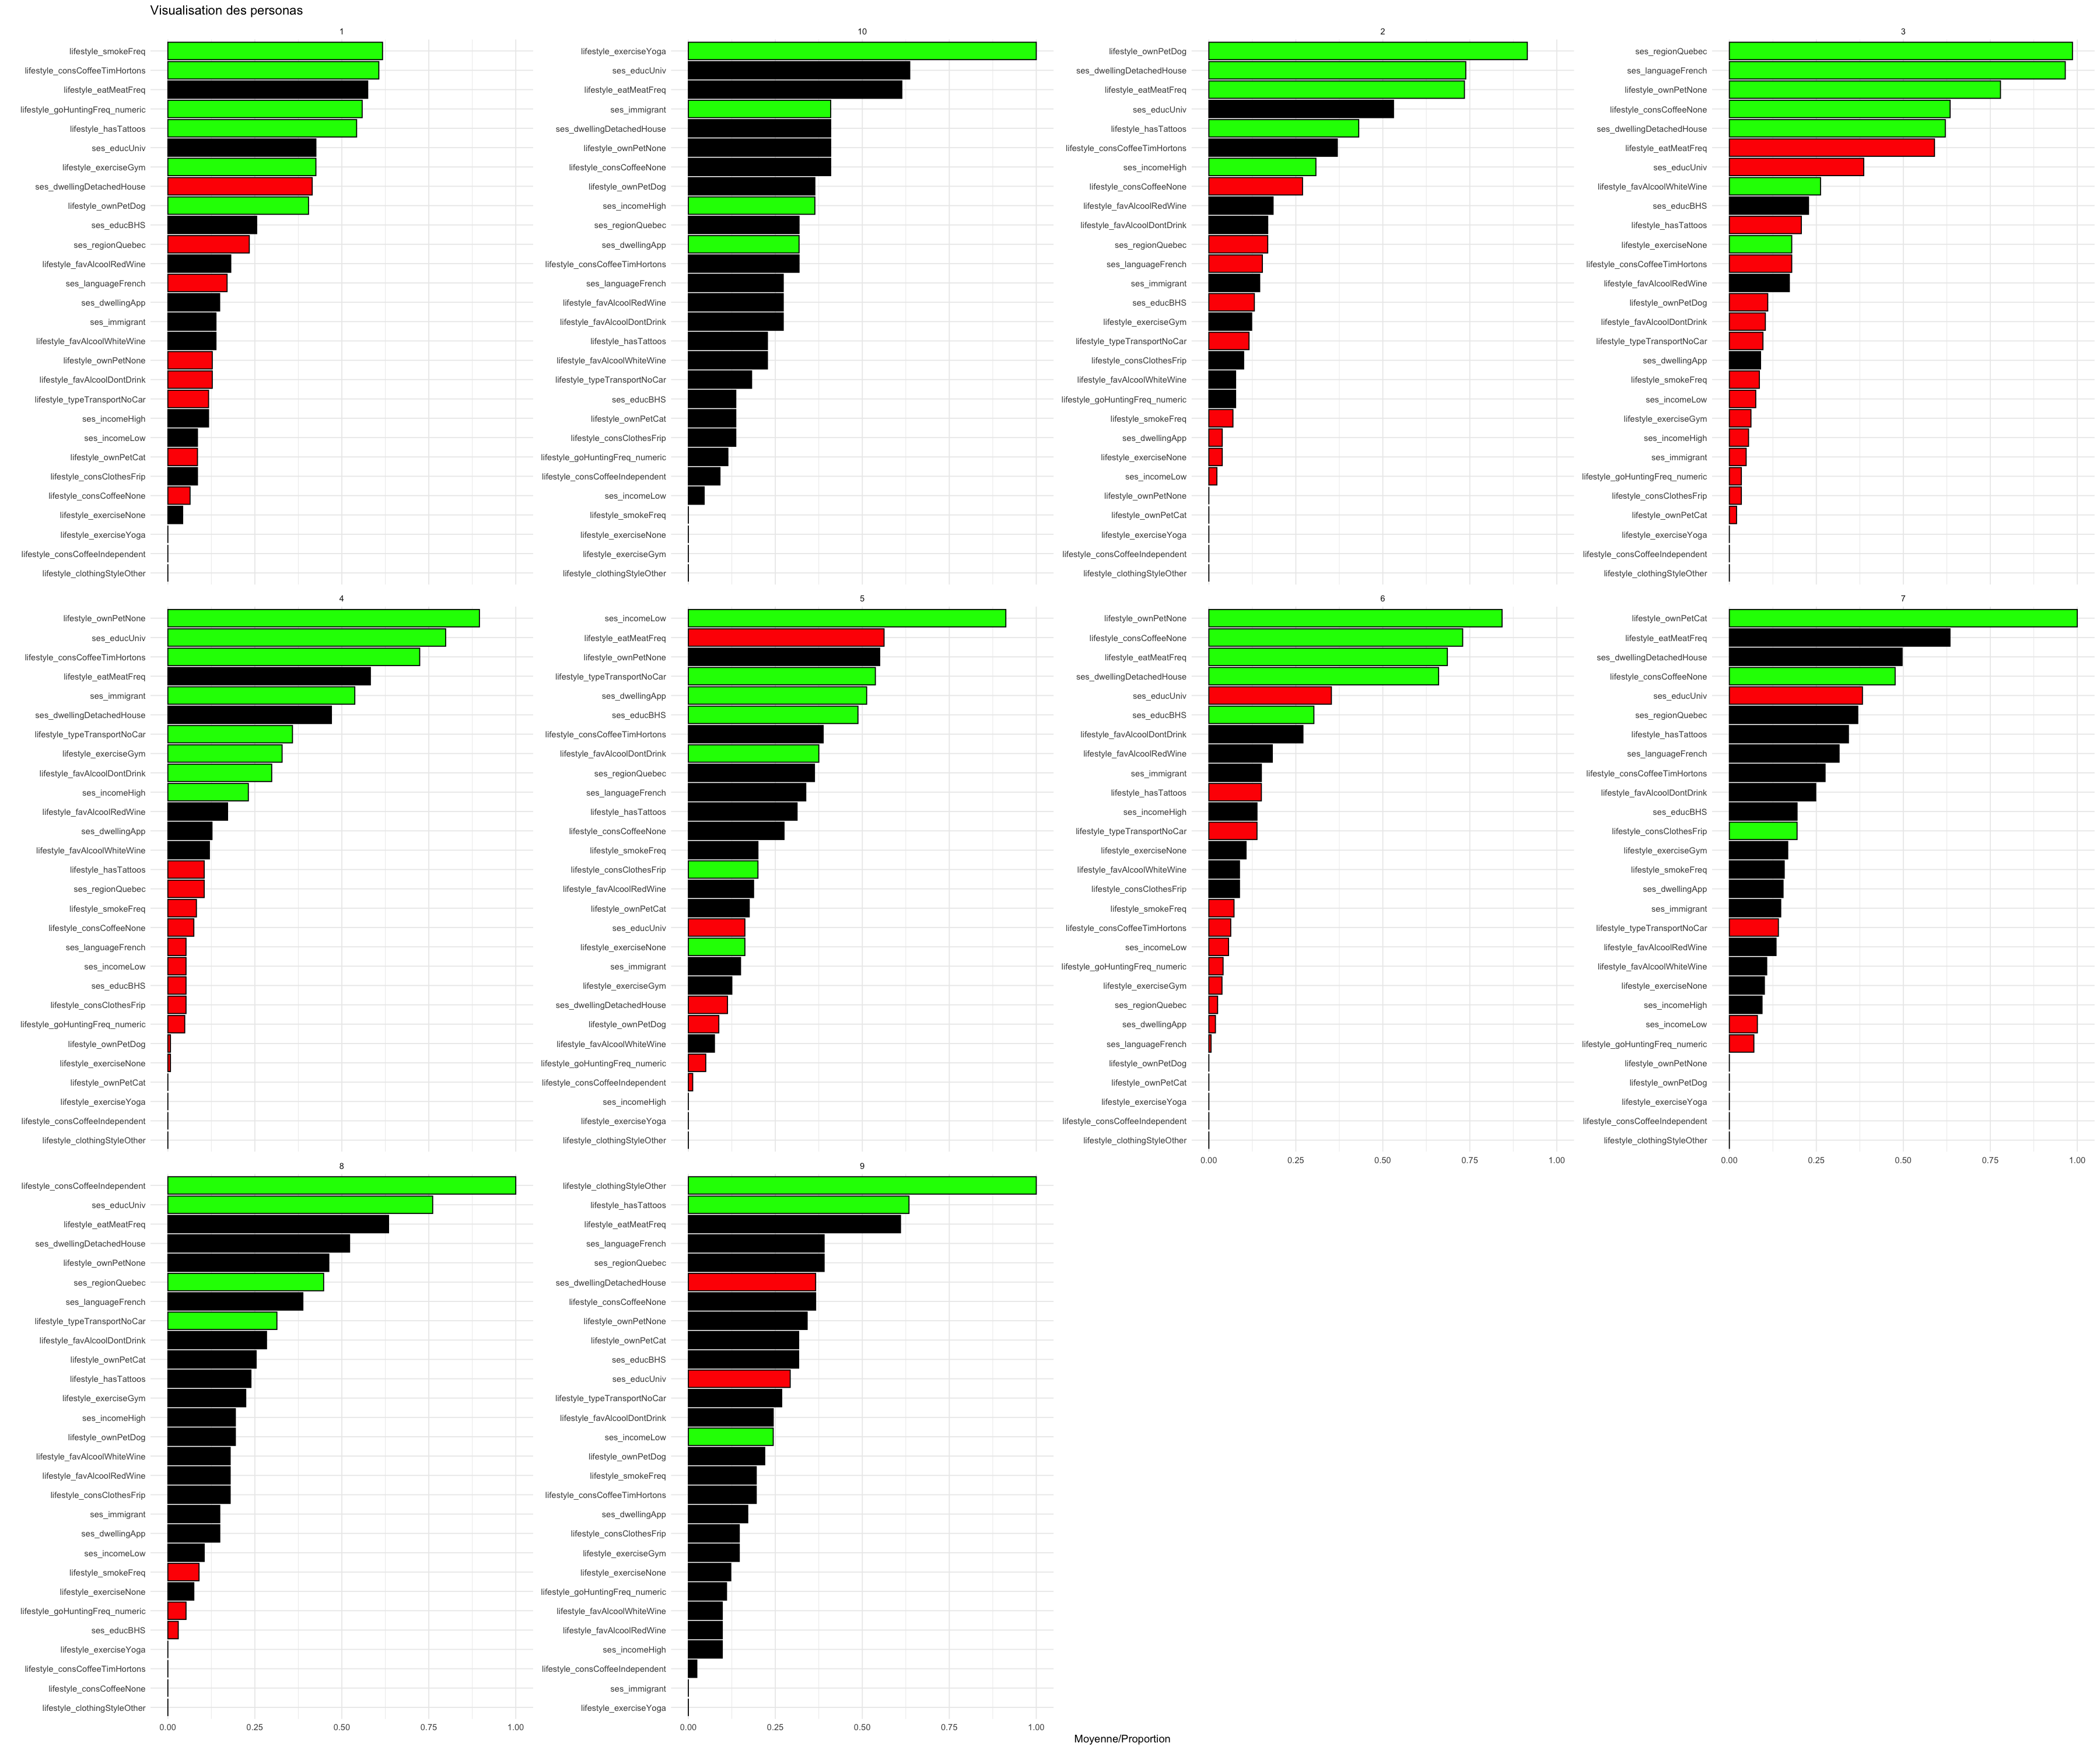

In [13]:
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 30, repr.plot.height = 25)

df_joined <- df_means %>%
  left_join(df_colors, by = c("variable", "cluster_name"))

# Tri des données pour le graphique
all_data_viz <- df_joined %>%
  group_by(cluster_name) %>%
  arrange(desc(mean_per_cluster)) %>%
  ungroup() %>%
  mutate(cluster_name = as.factor(cluster_name),
         variable = as.character(variable))

# Afficher le graphique
ggplot(all_data_viz, aes(x = reorder_within(variable, mean_per_cluster, cluster_name), y = mean_per_cluster, fill = color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ cluster_name, scales = "free_y") +
  scale_x_reordered()

variable,cluster_name,mean_per_cluster,mean_overall,color
<chr>,<chr>,<dbl>,<dbl>,<chr>
lifestyle_smokeFreq,1,0.61702128,0.15230167,green
lifestyle_consCoffeeTimHortons,1,0.60638298,0.31831538,green
lifestyle_goHuntingFreq_numeric,1,0.55851064,0.10333007,green
lifestyle_hasTattoos,1,0.54255319,0.29187071,green
lifestyle_exerciseGym,1,0.42553191,0.16748286,green
ses_dwellingDetachedHouse,1,0.41489362,0.52399608,red
lifestyle_ownPetDog,1,0.40425532,0.20666014,green
ses_regionQuebec,1,0.23404255,0.33496572,red
ses_languageFrench,1,0.17021277,0.29970617,red


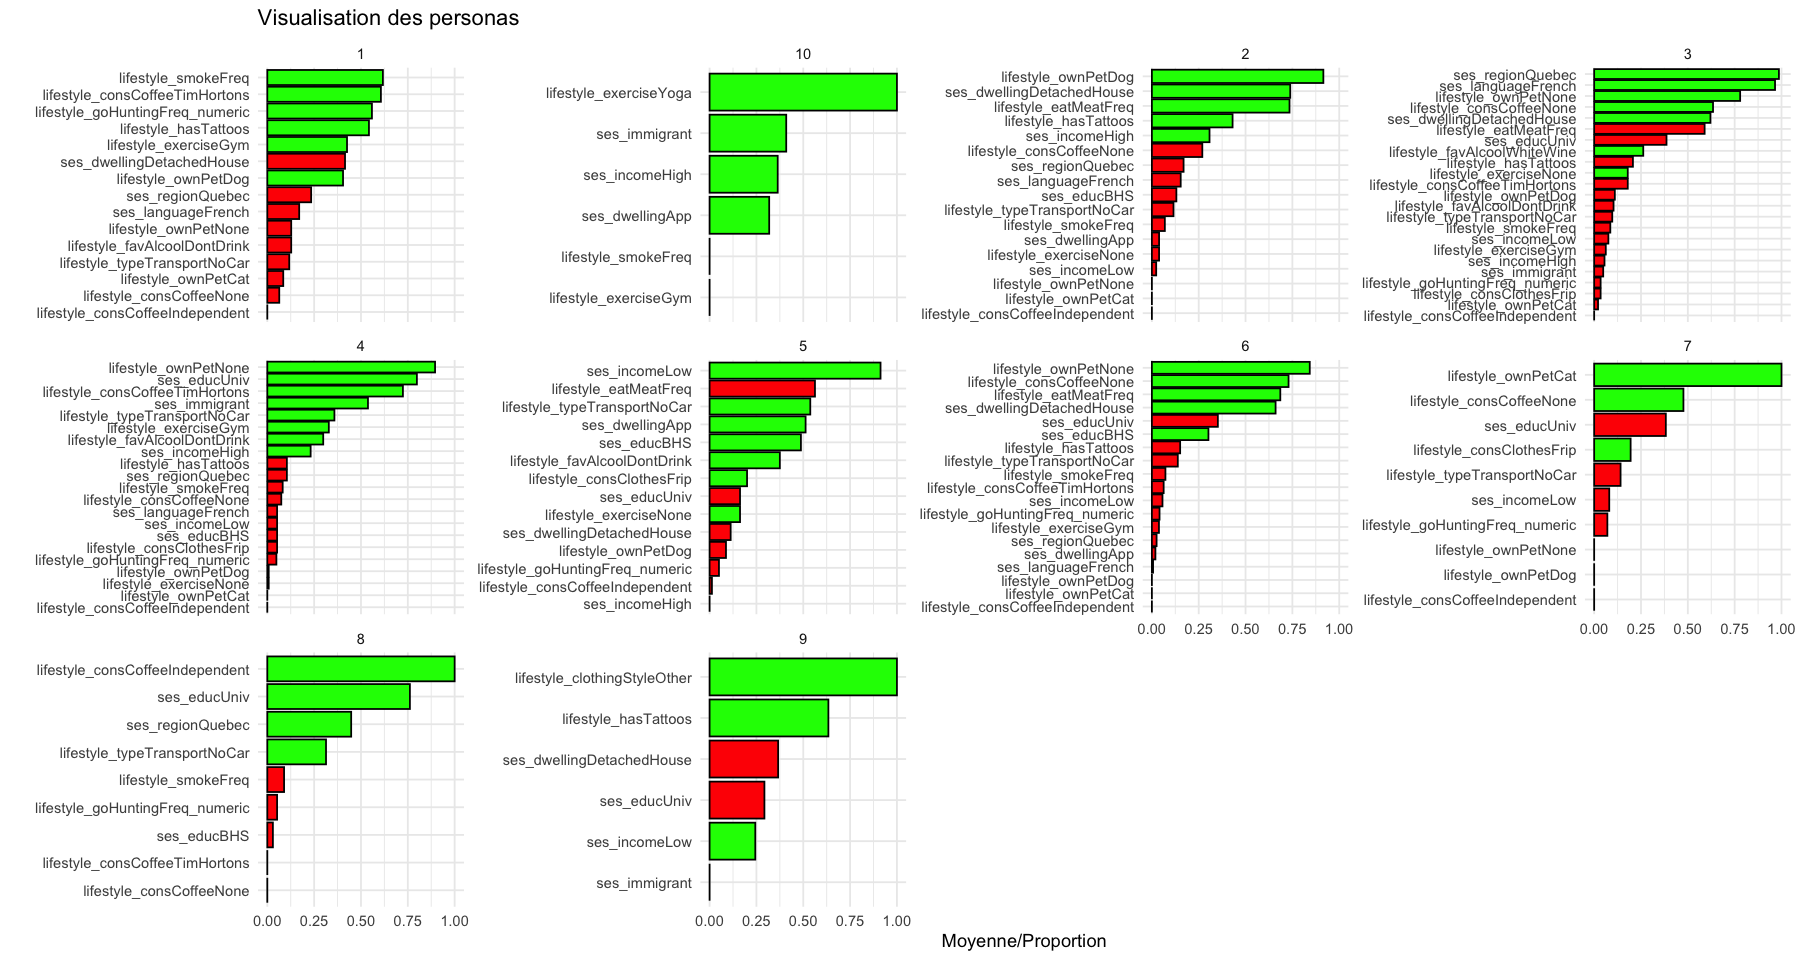

In [14]:
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 15, repr.plot.height = 8)

# Afficher les variables distinctives par clusters
all_data_viz_signif <- all_data_viz %>%
  filter(color %in% c("green", "red"))

# Afficher le graphique
ggplot(all_data_viz_signif, aes(x = reorder_within(variable, mean_per_cluster, cluster_name), y = mean_per_cluster, fill = color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ cluster_name, scales = "free_y") +
  scale_x_reordered()

df_distinctives_vars <- df_joined[which(df_joined$color != "black"),]
df_distinctives_vars <- df_distinctives_vars[order(df_distinctives_vars$cluster_name, desc(df_distinctives_vars$mean_per_cluster)),]
df_distinctives_vars

In [15]:
# Sauvegarder la table des mesures qui permettent d'identifier les variables significatives par clusters
saveRDS(df_joined, file = "../../_PrivateFolder_datagotchi_federal_2025/data/clustering/can2025/03_pilot_clusters_composition.rds")